In [1]:
import pandas as pd
import eia
import requests
import json
import yaml
from prophet import Prophet

# Definitions
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
pd.set_option('display.max_columns', 100)    #Display upto 100 columns 
pd.set_option('display.max_rows', 100) 
%matplotlib inline

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')   

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# To be able to pull modules from src folder 
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

## Pulling Raw Data 
So far, this pulls raw data for Total Net Generation from EIA API for all states in yaml. Eventually this will be extended to pull more types of data (such as generation by fuels, btu consumption by fuel, etc.) 

In [3]:
from d00_utils.utils import setup_env_vars
from d01_data.get_raw_data import load_data

setup_env_vars()
load_data()

2022-02-25 10:56:51,610 - Finding .env file to load entries as environment variables...
2022-02-25 10:56:51,614 - Finished loading environment variables.
2022-02-25 10:56:51,615 - Starting Raw Data Pull using EIA API...
2022-02-25 10:56:52,440 - Finished Raw Data Pull as JSON files.
2022-02-25 10:56:52,441 - Creating Intermediate Data...
2022-02-25 10:56:52,896 - Finished Creating Intermediate Data CSVs.


## Intermediate / Processed Data

In [4]:
YML_FILE_PATH = os.path.join(os.getcwd(), '../conf/base/', 'states.yml')
RAW_DATA_FOLDER = os.path.join(os.getcwd(), '../data/01_raw/')
INTERMEDIATE_DATA_FOLDER = os.path.join(os.getcwd(), '../data/02_intermediate/')

net_gen_ID = 'ELEC.GEN.ALL-{}-99.Q'
file_name = 'Net_Gen_By_State/net_generation_{}.{}'

def get_states_yml():
    states_yaml = open(YML_FILE_PATH)
    return yaml.load(states_yaml, Loader=yaml.FullLoader)

In [5]:
states = get_states_yml()
states

['AL', 'AR']

In [92]:
raw_file_path = os.path.join(RAW_DATA_FOLDER, file_name)
intermediate_file_path = os.path.join(INTERMEDIATE_DATA_FOLDER, file_name)

for state in states: 
    with open(raw_file_path.format(state, 'json'), 'r') as f:
        json_data = json.load(f)
        df = pd.DataFrame(json_data['series'][0]['data'])
        df.columns=["date", "net_generation"]
        
        # Convert year_quarter (2021Q3) into date ('2021-09-30) format 
        qs = df['date'].str.replace(r'(\d+)(Q\d)', r'\1-\2') 
        df['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp() 
        df['date'] = df['date'] + pd.offsets.QuarterEnd(0)
        # df.to_csv(intermediate_file_path.format(state, 'csv'), index=False)
        df.to_csv('test_intermediate_{}.csv'.format(state), index=False, date_format='%Y-%m-%d')

## Processed Data

Take intermediate data and perform any required preprocessing to get data ready for model training and testing 

In [90]:
from pandas import to_datetime
test_df_AL = pd.read_csv('test_intermediate_AL.csv')
test_df_AL['date'] = to_datetime(test_df_AL['date'])
# test_df_AL.plot('date','net_generation')
# test_df_AL.info()
test_df_AL.head()

,date,net_generation
0,2021-09-30,39835.274
1,2021-06-30,32450.840
2,2021-03-31,34144.667
3,2020-12-31,32301.295
4,2020-09-30,39516.706


In [ ]:
test_df_AL.columns = ['ds', 'y']
test_df_AL

### Test completed pipeline so far 

In [93]:
from d00_utils.utils import setup_env_vars
from d01_data.get_raw_data import load_data
from d03_processing.create_model_input import process_data

setup_env_vars()
load_data()
process_data()

2022-02-25 14:04:41,143 - Finding .env file to load entries as environment variables...
2022-02-25 14:04:41,146 - Finished loading environment variables.
2022-02-25 14:04:41,147 - Starting Raw Data Pull using EIA API...
2022-02-25 14:04:41,887 - Finished Raw Data Pull as JSON files.
2022-02-25 14:04:41,888 - Creating Intermediate Data...
2022-02-25 14:04:41,910 - Finished Creating Intermediate Data CSVs.
2022-02-25 14:04:41,911 - Creating Processed Data for model inputs...
2022-02-25 14:04:41,927 - Finished creating processed data.


## Prophet Training

In [75]:
df = test_df_AL.rename(columns={'date':'ds', 'net_generation':'y'})
m = Prophet()
m.fit(df)

2022-02-25 11:46:16,434 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-02-25 11:46:16,435 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -90.7397
Iteration  1. Log joint probability =     101.09. Improved by 191.83.
Iteration  2. Log joint probability =    152.338. Improved by 51.2477.
Iteration  3. Log joint probability =    202.528. Improved by 50.1907.
Iteration  4. Log joint probability =    219.155. Improved by 16.6265.
Iteration  5. Log joint probability =    219.197. Improved by 0.0424827.
Iteration  6. Log joint probability =    223.349. Improved by 4.15211.
Iteration  7. Log joint probability =    224.007. Improved by 0.657233.
Iteration  8. Log joint probability =    226.755. Improved by 2.74808.
Iteration  9. Log joint probability =    238.052. Improved by 11.2974.
Iteration 10. Log joint probability =     243.12. Improved by 5.06797.
Iteration 11. Log joint probability =    243.281. Improved by 0.161307.
Iteration 12. Log joint probability =    245.026. Improved by 1.74467.
Iteration 13. Log joint probability =    247.957. Improved by 2.93105.
Iteration 14. Log joint probabili

### Save & Load Fitted Models 

In [ ]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

with open('serialized_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model


### Test completed pipeline with Prophet Training

In [95]:
from d00_utils.utils import setup_env_vars
from d01_data.get_raw_data import load_data
from d03_processing.create_model_input import process_data
from d04_modelling.create_prophet_models import train_models

setup_env_vars()
load_data()
process_data()
train_models()

2022-02-25 14:22:55,631 - Finding .env file to load entries as environment variables...
2022-02-25 14:22:55,634 - Finished loading environment variables.
2022-02-25 14:22:55,635 - Starting Raw Data Pull using EIA API...
2022-02-25 14:22:57,522 - Finished Raw Data Pull as JSON files.
2022-02-25 14:22:57,523 - Creating Intermediate Data...
2022-02-25 14:22:57,544 - Finished Creating Intermediate Data CSVs.
2022-02-25 14:22:57,545 - Creating Processed Data for model inputs...
2022-02-25 14:22:57,561 - Finished creating processed data.
2022-02-25 14:22:57,562 - Training and Saving Prophet Models...
2022-02-25 14:22:57,586 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-02-25 14:22:57,587 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-02-25 14:22:59,403 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-02-25 14:22:59,404 - Disabling daily seasonality. 

## Model Predictions and Outputs 

In [76]:
# Makes a dataframe with both historical dates and appended future dates for number of periods specified
future = m.make_future_dataframe(periods=16, freq='Q')
future.tail()

,ds
94,2024-09-30
95,2024-12-31
96,2025-03-31
97,2025-06-30
98,2025-09-30


In [102]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
94,2024-09-30,37604.705,36265.545,38952.595
95,2024-12-31,31065.140,29679.571,32390.460
96,2025-03-31,31725.660,30412.247,33075.554
97,2025-06-30,31488.515,29993.626,32895.137
98,2025-09-30,36666.583,35188.110,38039.695


### Test completed pipeline with Model Forecasting

In [103]:
from d00_utils.utils import setup_env_vars
from d01_data.get_raw_data import load_data
from d03_processing.create_model_input import process_data
from d04_modelling.create_prophet_models import train_models
from d06_reporting.create_forecasts import create_forecasts

setup_env_vars()
load_data()
process_data()
train_models()
create_forecasts()

2022-02-25 14:54:06,858 - Finding .env file to load entries as environment variables...
2022-02-25 14:54:06,861 - Finished loading environment variables.
2022-02-25 14:54:06,862 - Starting Raw Data Pull using EIA API...
2022-02-25 14:54:07,406 - Finished Raw Data Pull as JSON files.
2022-02-25 14:54:07,407 - Creating Intermediate Data...
2022-02-25 14:54:07,429 - Finished Creating Intermediate Data CSVs.
2022-02-25 14:54:07,430 - Creating Processed Data for model inputs...
2022-02-25 14:54:07,447 - Finished creating processed data.
2022-02-25 14:54:07,448 - Training and Saving Prophet Models...
2022-02-25 14:54:07,470 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-02-25 14:54:07,471 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-02-25 14:54:09,230 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-02-25 14:54:09,230 - Disabling daily seasonality. 

## Forecast Plots 

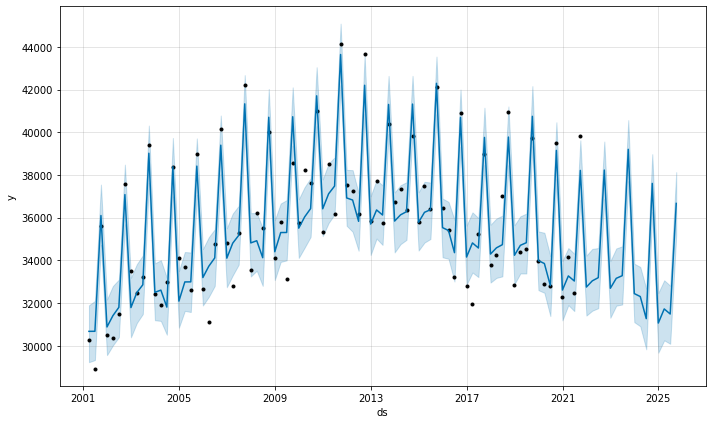

In [78]:
# Non-interactive plots
fig1 = m.plot(forecast)
# fig2 = m.plot_components(forecast)

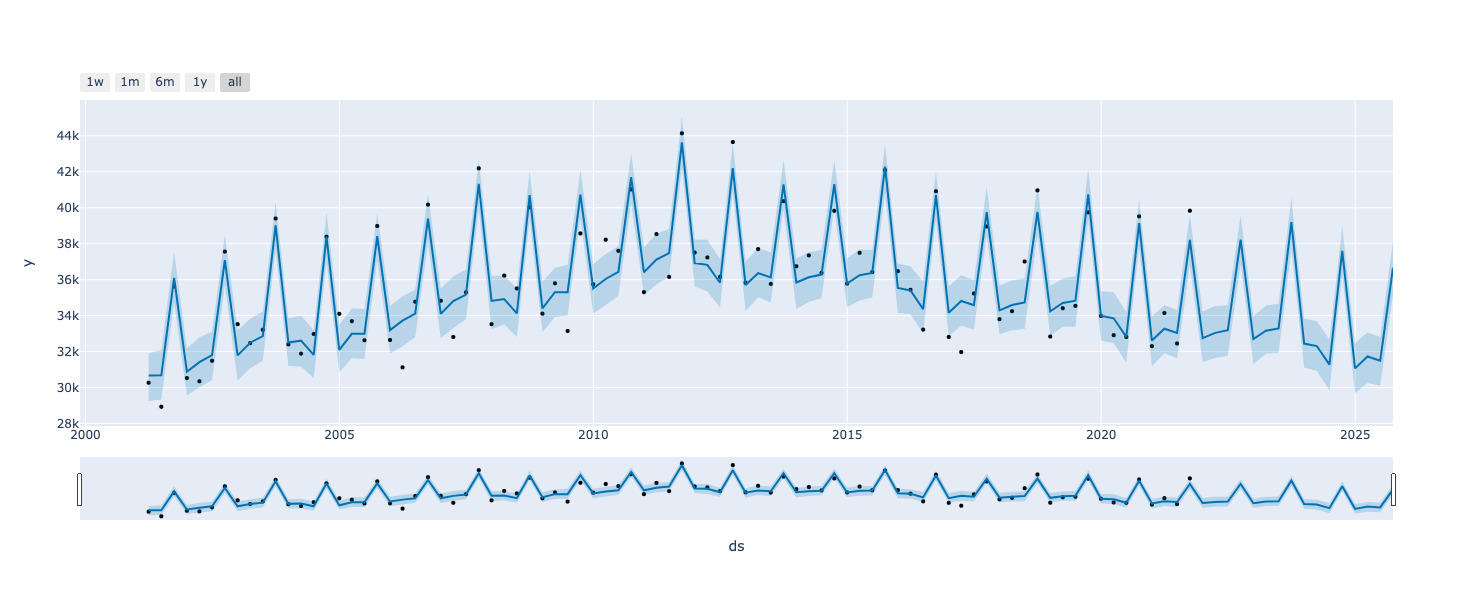

In [99]:
from prophet.plot import plot_plotly, plot_components_plotly

# Interative Plots
plot_plotly(m, forecast)
# plot_components_plotly(m, forecast)

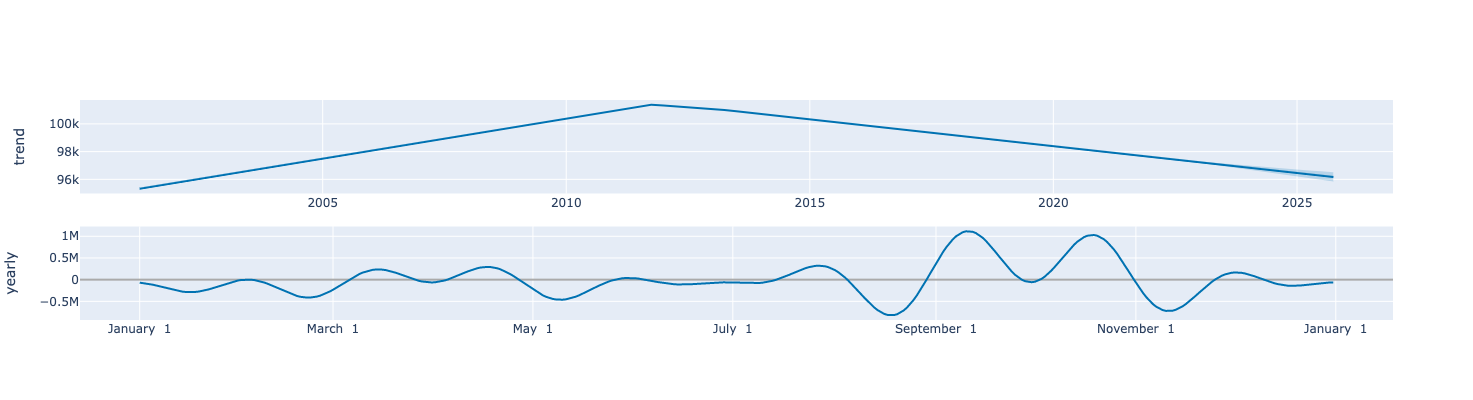

In [101]:
plot_components_plotly(m, forecast)

# Appendix 

## Model Evaluation with Validation Set

In [81]:
# Remove last 12 quarters of measurements and use as validation set 
train = df.drop(df.index[:12])
print(train.head())

m2 = Prophet()
m2.fit(train)

2022-02-25 11:47:21,336 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-02-25 11:47:21,337 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds         y
12 2018-09-30 40964.807
13 2018-06-30 37009.625
14 2018-03-31 34245.419
15 2017-12-31 33803.644
16 2017-09-30 38957.858



Initial log joint probability = -79.6255
Iteration  1. Log joint probability =    79.5885. Improved by 159.214.
Iteration  2. Log joint probability =    129.894. Improved by 50.305.
Iteration  3. Log joint probability =     160.85. Improved by 30.9568.
Iteration  4. Log joint probability =    188.253. Improved by 27.4032.
Iteration  5. Log joint probability =    199.602. Improved by 11.3486.
Iteration  6. Log joint probability =    199.672. Improved by 0.0704776.
Iteration  7. Log joint probability =    199.753. Improved by 0.0805985.
Iteration  8. Log joint probability =    199.905. Improved by 0.152393.
Iteration  9. Log joint probability =    200.096. Improved by 0.190036.
Iteration 10. Log joint probability =     200.27. Improved by 0.174804.
Iteration 11. Log joint probability =     200.37. Improved by 0.099416.
Iteration 12. Log joint probability =    200.378. Improved by 0.00809057.
Iteration 13. Log joint probability =    200.907. Improved by 0.529447.
Iteration 14. Log joint 

In [84]:
validation = m2.make_future_dataframe(periods=12, freq='Q')
forecast2 = m2.predict(validation[-12:])
y_pred = forecast2['yhat'].values
y_true = df['y'][:12].values

mae = mean_absolute_error(y_true, y_pred)
mae

3658.815425184068

In [ ]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# # calculate MAE between expected and predicted values for next 60 mont
# y_true = data['y'].values
# y_pred = forecast['yhat'][:252].values
# mae = mean_absolute_error(y_true, y_pred)
# print('MAE: %.3f' % mae)
# r = r2_score(y_true, y_pred)
# print('R-squared Score: %.3f' % r)

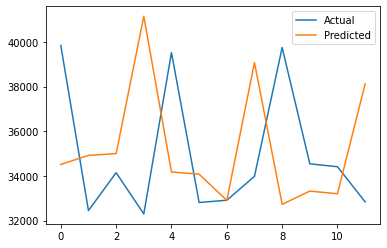

In [85]:
from matplotlib import pyplot
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

### Cross-Validation using Prophet

#TODO: Perform model tuning after setting up initial end-to-end pipeline

In [ ]:
# from prophet.diagnostics import cross_validation
# df_cv = cross_validation(m, horizon = '365 days')

# from prophet.diagnostics import performance_metrics
# df_p = performance_metrics(df_cv)
# df_p